In [1]:
import json
import time
from collections import Counter, defaultdict
from datetime import datetime

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA

from src.data.make_dataset import CONSPIRACY_SUBREDDITS, DEFAULT_SUBREDDITS
from src.features.perspective import parse_summary_scores
from src.visualization.mca import plot_mca
import os

In [2]:
external_dir = '../data/external/'
ct = pd.read_csv(os.path.join(external_dir, 'conspiracy_svd_cossim_vector.csv'), index_col=0).rename(
    columns={'similarity': 'conspiracy'})
dims = pd.read_csv(os.path.join(external_dir, 'scores.csv'), index_col=0)

dims = dims[['age', 'affluence', 'gender', 'partisan', 'partisan neutral']] #'gender neutral', 'partisan neutral'
dims = pd.merge(dims, ct, left_index=True, right_index=True, how='outer')
dims = dims.apply(lambda x: pd.qcut(x, 10, labels=False), axis=0)
top_bottom_communities = {col: {'top':dims[dims[col]==9].index.values, 
       'bottom':dims[dims[col]==0].index.values, } for col in dims.columns}
top_bottom_communities = {f'{k}_{kk}': set(top_bottom_communities[k][kk]) for k in top_bottom_communities for kk in ['top', 'bottom']}

In [3]:
with open('../data/interim/counts/subreddit_counts.json') as f:
    subreddit_counts = json.load(f)

In [4]:
len(subreddit_counts)

14126585

In [5]:
def truncate_timestamp(timestamp):
    timestamp = datetime.fromtimestamp(float(timestamp))
    truncated_timestamp = time.mktime(timestamp.date().timetuple())
    return truncated_timestamp


subreddit_counts = {k:({truncate_timestamp(i): j for i, j in v.items()}) for k, v in subreddit_counts.items()}

In [6]:
top_bottom_counters = defaultdict(Counter)
for series_name, communities in top_bottom_communities.items():
    for community in communities:
        top_bottom_counters[series_name]+=subreddit_counts[community]

In [7]:
top_bottom_counters = pd.DataFrame(top_bottom_counters)

In [8]:
top_bottom_counters = top_bottom_counters.reset_index(names='day_timestamp')
top_bottom_counters['day_datetime'] = top_bottom_counters.day_timestamp.apply(lambda x:datetime.fromtimestamp(x))
top_bottom_counters.fillna(0, inplace=True)
del top_bottom_counters['day_timestamp']
top_bottom_counters = top_bottom_counters.set_index('day_datetime')
top_bottom_counters.head()

,age_top,age_bottom,affluence_top,affluence_bottom,gender_top,gender_bottom,partisan_top,partisan_bottom,partisan neutral_top,partisan neutral_bottom,conspiracy_top,conspiracy_bottom
day_datetime,,,,,,,,,,,,
2008-06-02,17537,541.0,22258,19.0,110.0,389.0,749.0,2245.0,5948.0,898.0,7115.0,10751
2008-06-03,21335,354.0,26294,39.0,235.0,441.0,613.0,2511.0,8078.0,667.0,8962.0,11444
2008-06-04,19061,321.0,23638,20.0,131.0,466.0,583.0,2618.0,6747.0,575.0,7423.0,11219
2008-06-05,16424,348.0,20610,15.0,164.0,291.0,523.0,2102.0,6923.0,639.0,7670.0,8712
2008-06-07,13632,244.0,16855,7.0,96.0,170.0,360.0,1806.0,5119.0,524.0,5459.0,7822


In [9]:
cntr= Counter()
cntr_ct = Counter()
cntr_default = Counter()
cntrs_topics = {k: Counter() for k in top_bottom_communities}
with open('../data/interim/labeling_contributions_preprocessed_no_bot.jsonl', encoding='utf8') as f:
    for contribution in map(json.loads, f):
        timestamp = contribution.get('created_utc', None)
        if timestamp:
            timestamp = datetime.fromtimestamp(float(timestamp))
            truncated_timestamp = time.mktime(timestamp.date().timetuple())
            cntr[truncated_timestamp]+=1
            contribution_subreddit = contribution.get('subreddit', None)
            if not contribution_subreddit: continue
            if contribution_subreddit in CONSPIRACY_SUBREDDITS:
                cntr_ct[truncated_timestamp]+=1
            elif contribution_subreddit in DEFAULT_SUBREDDITS:
                cntr_default[truncated_timestamp]+=1
                
            for topic, topic_subreddits in top_bottom_communities.items():
                if contribution_subreddit in topic_subreddits:
                    cntrs_topics[topic][truncated_timestamp]+=1

In [10]:
df = pd.DataFrame({'all':pd.Series(cntr, name='all'),
              'conspiracy_36':pd.Series(cntr_ct, name='conspiracy_36'),
              'default':pd.Series(cntr_default, name='default')}| {k:pd.Series(v, name=k) for k, v in cntrs_topics.items()},)

In [11]:
df.tail()

,all,conspiracy_36,default,age_top,age_bottom,affluence_top,affluence_bottom,gender_top,gender_bottom,partisan_top,partisan_bottom,partisan neutral_top,partisan neutral_bottom,conspiracy_top,conspiracy_bottom
1.677280e+09,513,52.0,33.0,40.0,22.0,33.0,26.0,18.0,17.0,66.0,38.0,156.0,NaN,139.0,6.0
1.677366e+09,639,44.0,106.0,47.0,23.0,30.0,29.0,7.0,18.0,77.0,33.0,234.0,7.0,237.0,6.0
1.677452e+09,903,61.0,117.0,71.0,29.0,59.0,35.0,8.0,19.0,104.0,55.0,296.0,6.0,272.0,2.0
1.677539e+09,699,60.0,51.0,70.0,22.0,34.0,60.0,19.0,14.0,78.0,59.0,235.0,4.0,226.0,5.0
1.677625e+09,27,1.0,1.0,5.0,NaN,1.0,7.0,NaN,1.0,2.0,3.0,15.0,NaN,13.0,NaN


In [12]:
df = df.reset_index(names='day_timestamp')
df['day_datetime'] = df.day_timestamp.apply(lambda x:datetime.fromtimestamp(x))
df.fillna(0, inplace=True)
del df['day_timestamp']
df = df.set_index('day_datetime')
df.head()

,all,conspiracy_36,default,age_top,age_bottom,affluence_top,affluence_bottom,gender_top,gender_bottom,partisan_top,partisan_bottom,partisan neutral_top,partisan neutral_bottom,conspiracy_top,conspiracy_bottom
day_datetime,,,,,,,,,,,,,,,
2005-12-30,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2006-01-16,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2006-02-02,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2006-02-07,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2006-04-05,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [13]:
df.rename(columns={'gender_top':'gender_male',
           'gender_bottom':'gender_female',
           'partisan_top':'political_right',
           'partisan_bottom':'political_left',
           'partisan neutral_top':'politics_partisan',
           'partisan neutral_bottom':'politics_neutral',
           'age_top':'age_older',
           'age_bottom':'age_younger',
           'conspiracy_top':'affiliation_conspiracy',
           'conspiracy_bottom':'affiliation_science',
           'affluence_top':'affluence_rich',
           'affluence_bottom':'affluence_poor',
           }, inplace=True)
top_bottom_counters.rename(columns={'gender_top':'gender_male',
           'gender_bottom':'gender_female',
           'partisan_top':'political_right',
           'partisan_bottom':'political_left',
           'partisan neutral_top':'politics_partisan',
           'partisan neutral_bottom':'politics_neutral',
           'age_top':'age_older',
           'age_bottom':'age_younger',
           'conspiracy_top':'affiliation_conspiracy',
           'conspiracy_bottom':'affiliation_science',
           'affluence_top':'affluence_rich',
           'affluence_bottom':'affluence_poor',
           }, inplace=True)

In [14]:
top_bottom_counters.head()

,age_older,age_younger,affluence_rich,affluence_poor,gender_male,gender_female,political_right,political_left,politics_partisan,politics_neutral,affiliation_conspiracy,affiliation_science
day_datetime,,,,,,,,,,,,
2008-06-02,17537,541.0,22258,19.0,110.0,389.0,749.0,2245.0,5948.0,898.0,7115.0,10751
2008-06-03,21335,354.0,26294,39.0,235.0,441.0,613.0,2511.0,8078.0,667.0,8962.0,11444
2008-06-04,19061,321.0,23638,20.0,131.0,466.0,583.0,2618.0,6747.0,575.0,7423.0,11219
2008-06-05,16424,348.0,20610,15.0,164.0,291.0,523.0,2102.0,6923.0,639.0,7670.0,8712
2008-06-07,13632,244.0,16855,7.0,96.0,170.0,360.0,1806.0,5119.0,524.0,5459.0,7822


gender


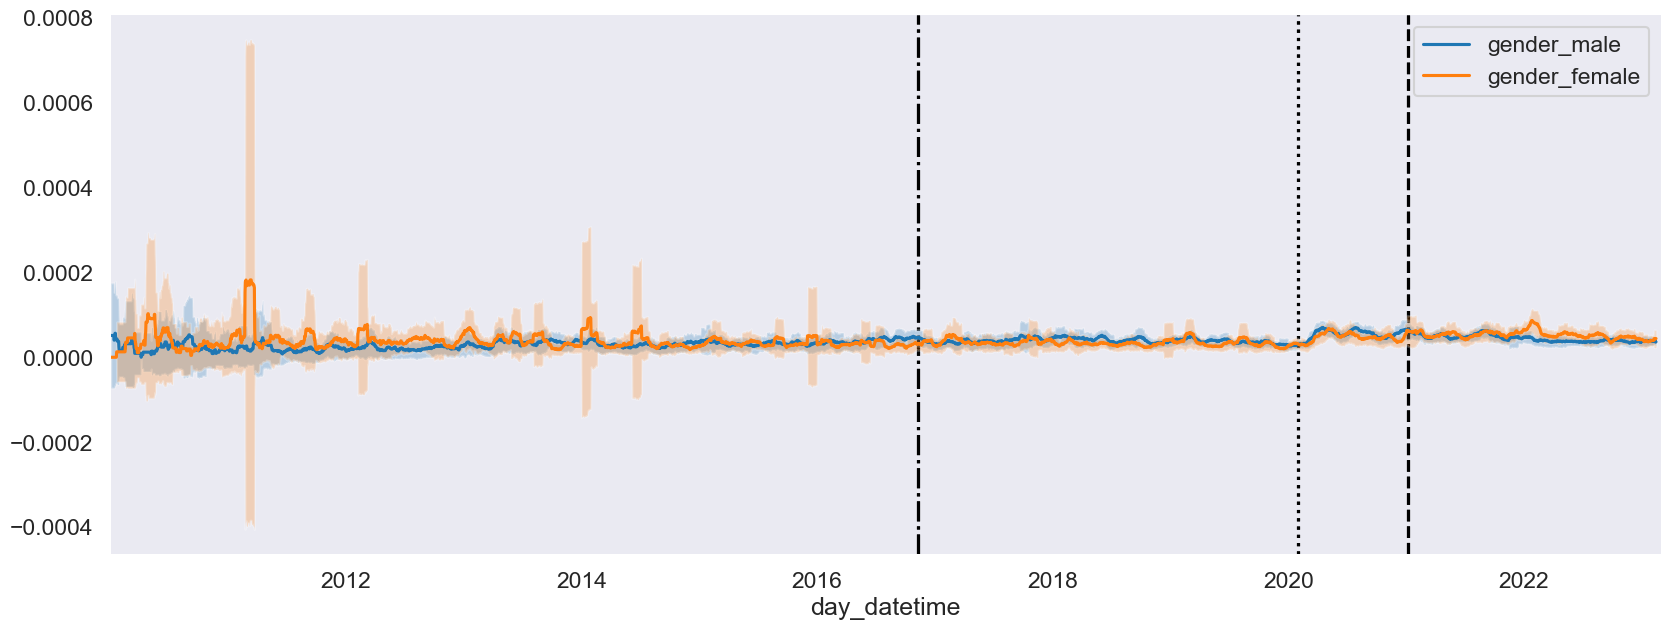

affiliation


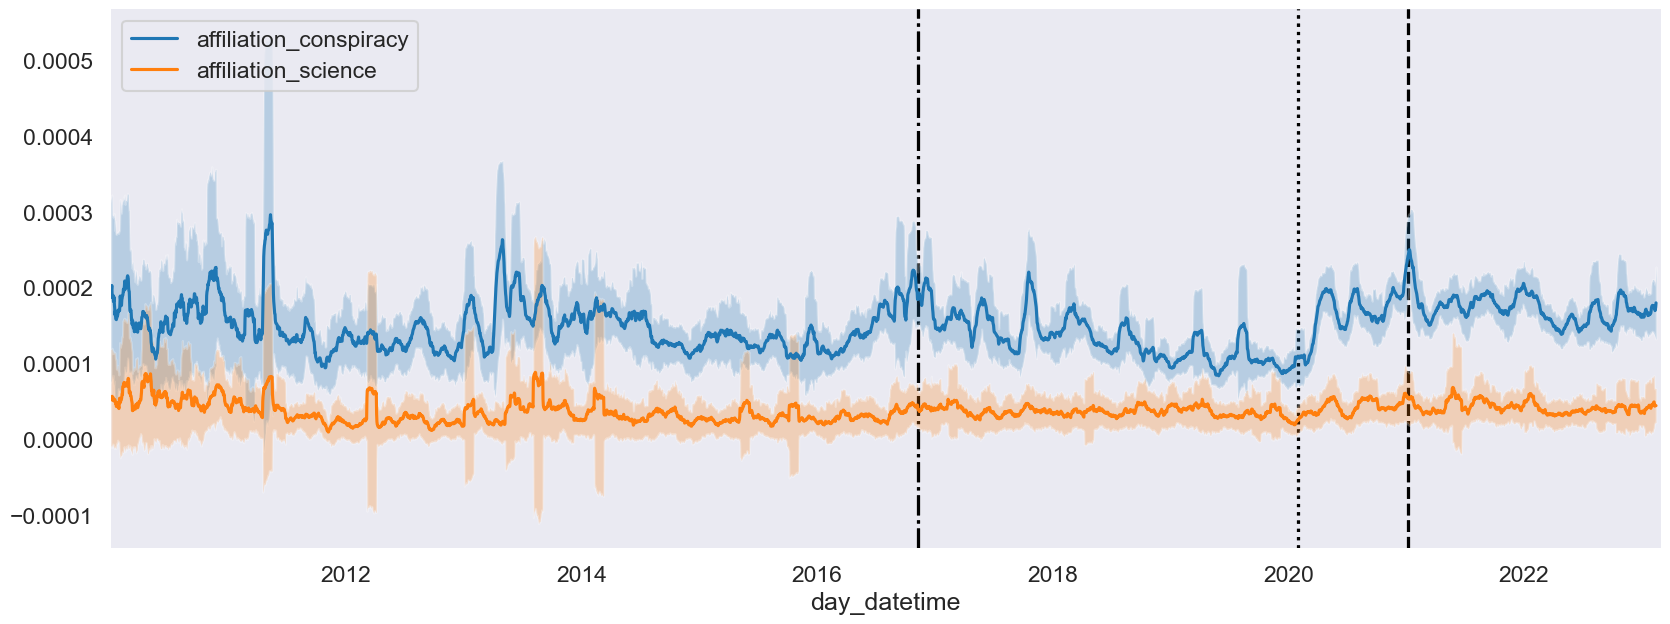

age


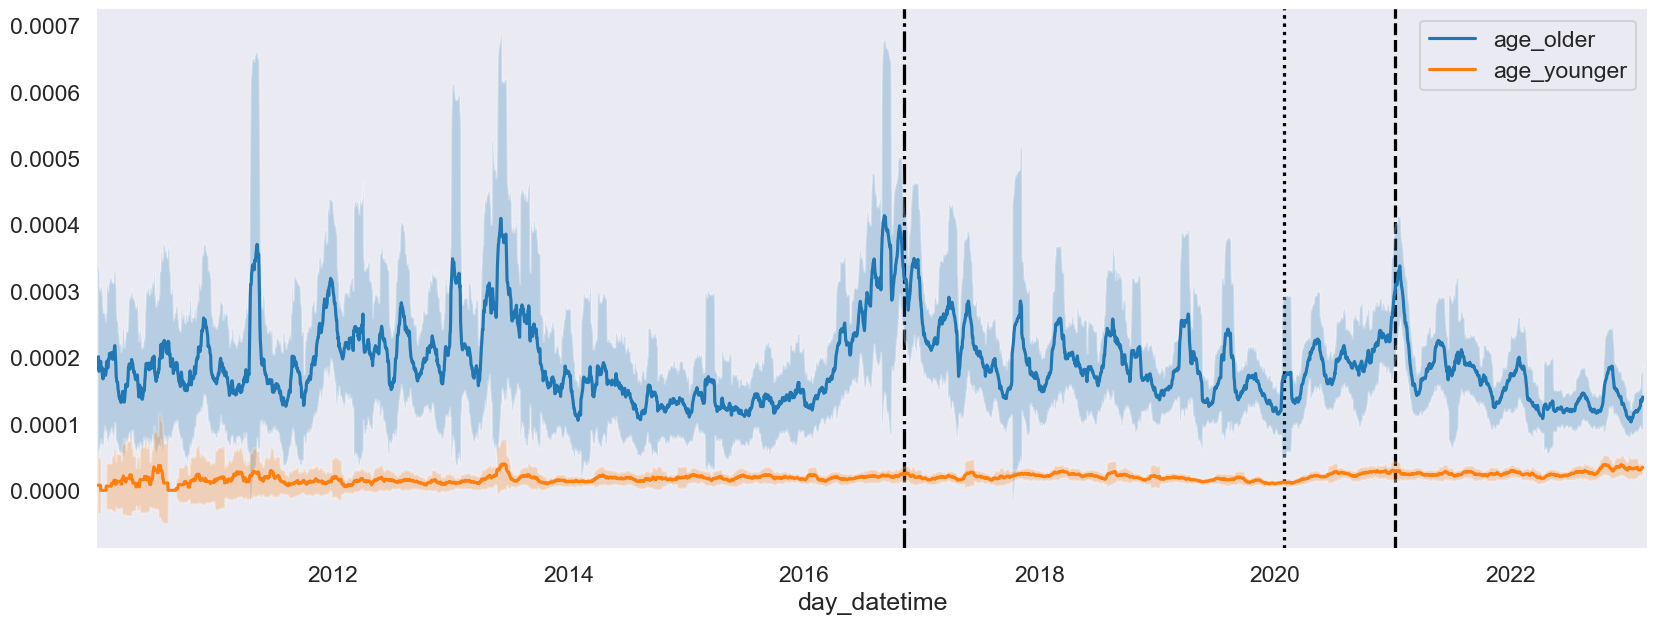

affluence


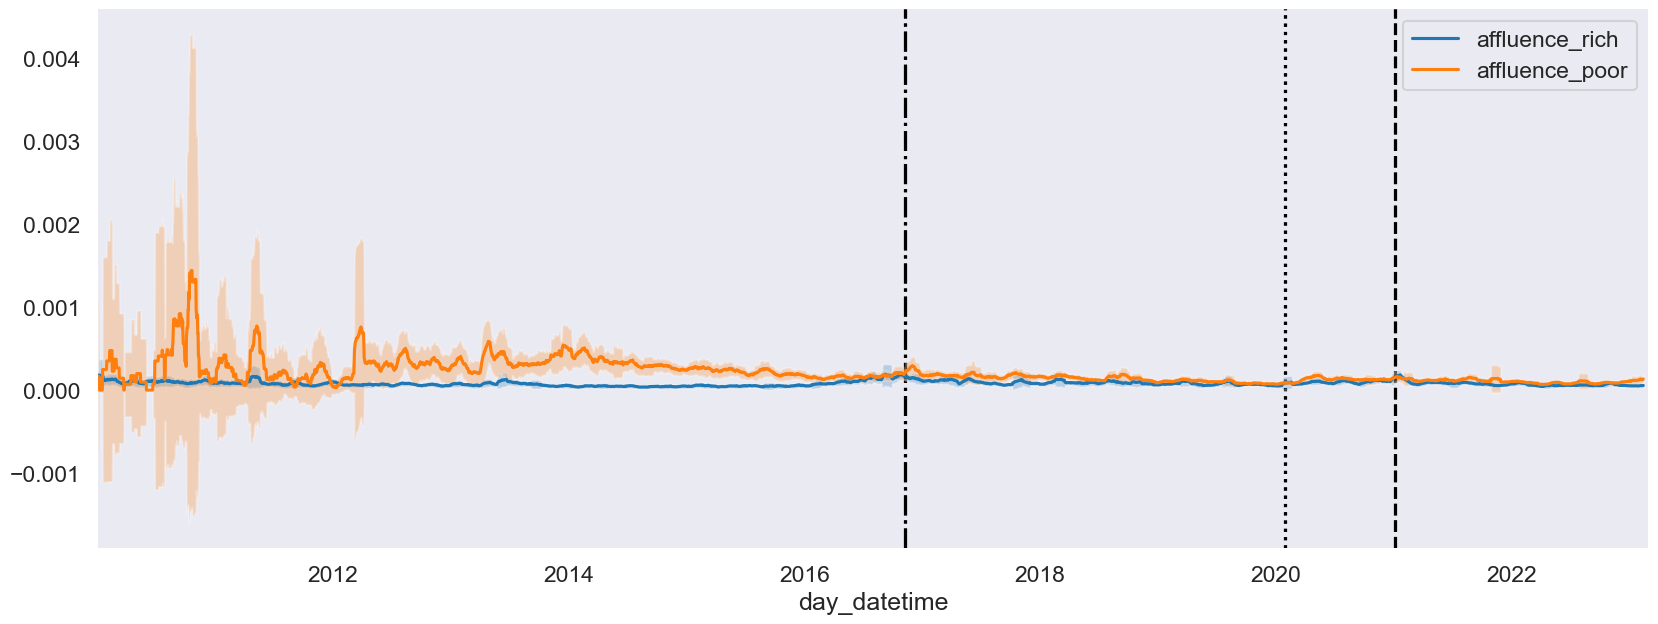

political


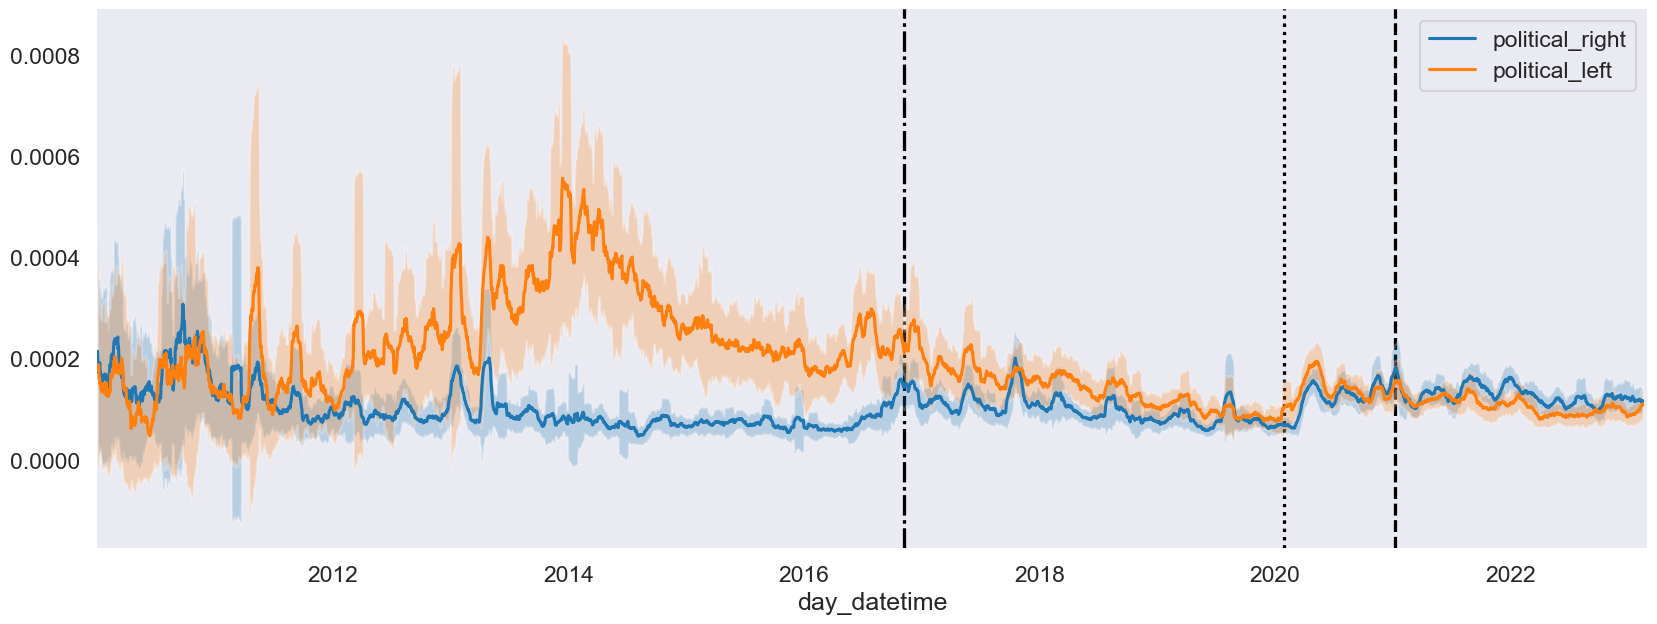

politics


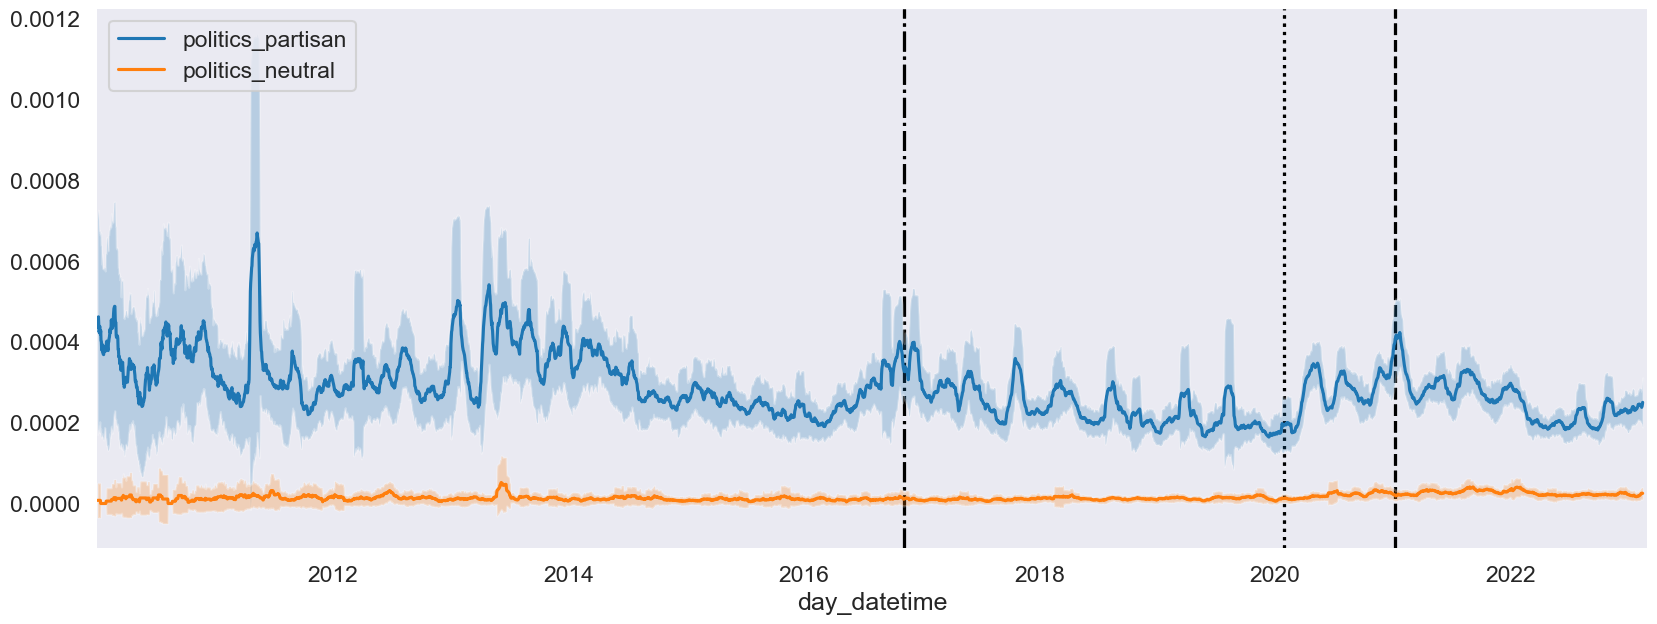

In [15]:


with sns.plotting_context("talk"):
    for col_filter in ['gender', 'affiliation', 'age', 'affluence', 'political', 'politics']:
        ax=None
        print(col_filter)
        for col in top_bottom_counters.columns:
            if col_filter not in col: continue
            roll = (df[col]/top_bottom_counters[col]).rolling(30, center=True)
            m = roll.agg(['mean', 'std'])
            m=m.loc[m.index>'2010']
            ax = m['mean'].rename(col).plot(figsize=(20, 7), ax=ax)
            ax.fill_between(m.index, m['mean'] - m['std'], m['mean'] + m['std'],
                            alpha=.25)
            plt.axvline(x = datetime.fromisoformat('2021-01-06'), color = 'k', ls='--', zorder=0)
            plt.axvline(x = datetime.fromisoformat('2020-01-30'), color = 'k', ls=':', zorder=0)
            plt.axvline(x = datetime.fromisoformat('2016-11-08'), color = 'k', ls='-.', zorder=0)
            plt.annotate('Capitol Hill attack', xy=(datetime.fromisoformat('2021-01-06'), 1000), rotation=90, va='bottom', ha='right', fontsize=16)
            plt.annotate('WHO COVID-19 emergency', xy=(datetime.fromisoformat('2020-01-30'), 1000), rotation=90, va='bottom', ha='right', fontsize=16)
            plt.annotate('election of Donald J. Trump', xy=(datetime.fromisoformat('2016-11-08'), 1000), rotation=90, va='bottom', ha='right', fontsize=16)
            sns.despine(ax=ax, left=True, bottom=True)
            ax.grid(False)
            # ax.set_ylim(-.001, .001)
        plt.legend()
        plt.show()

gender


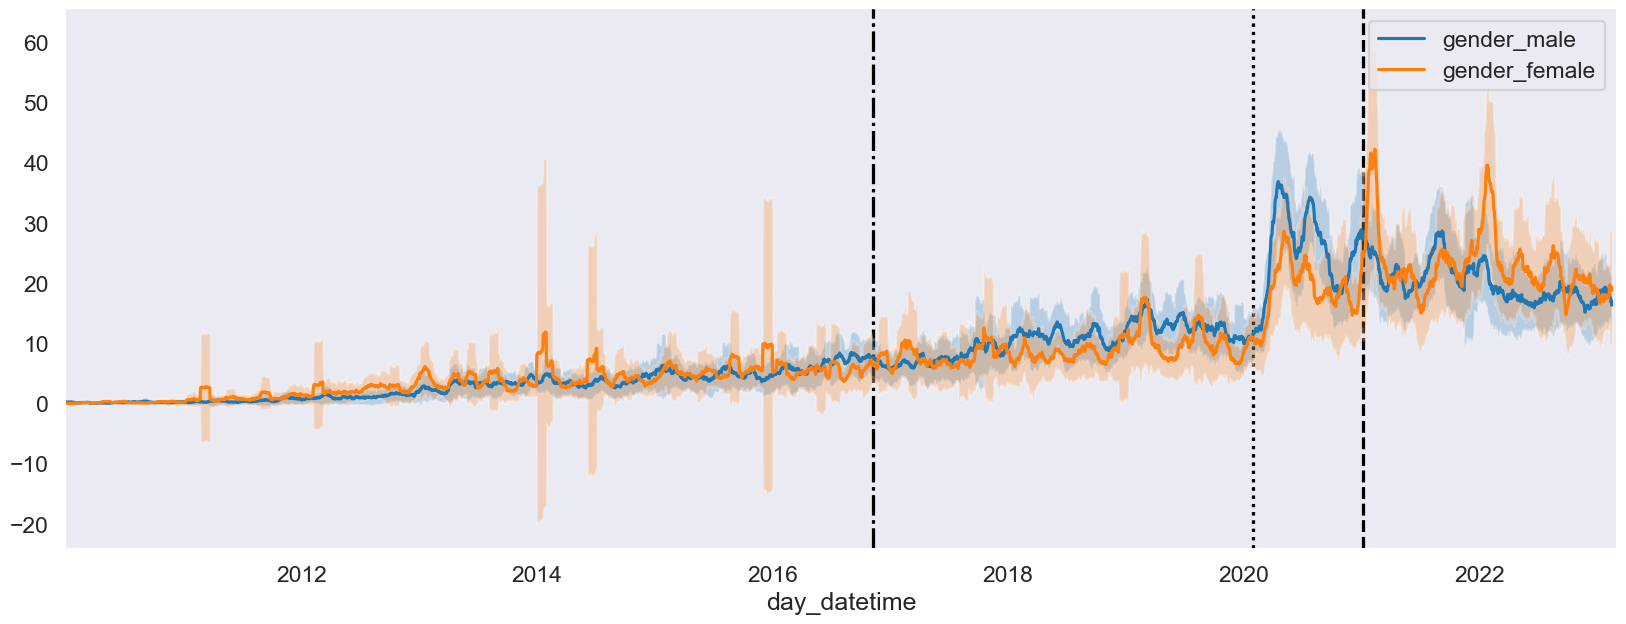

affiliation


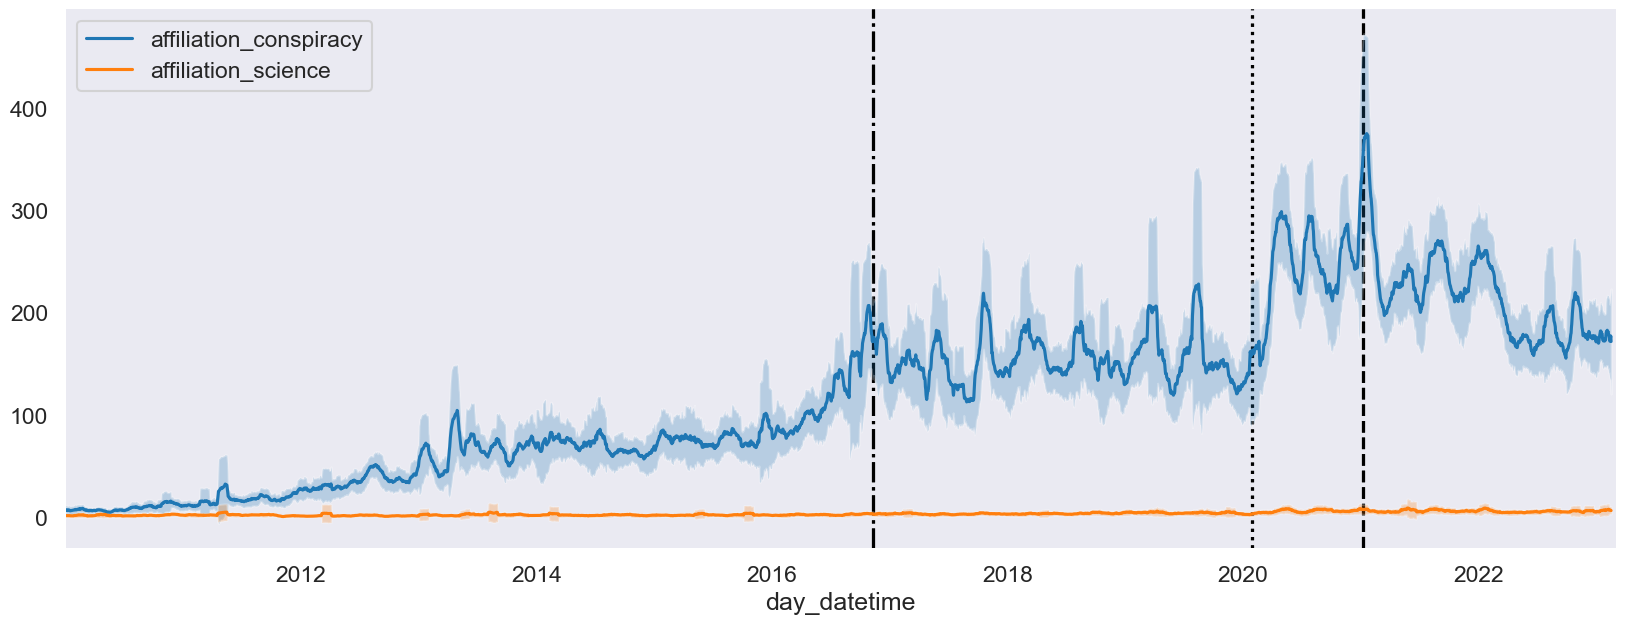

age


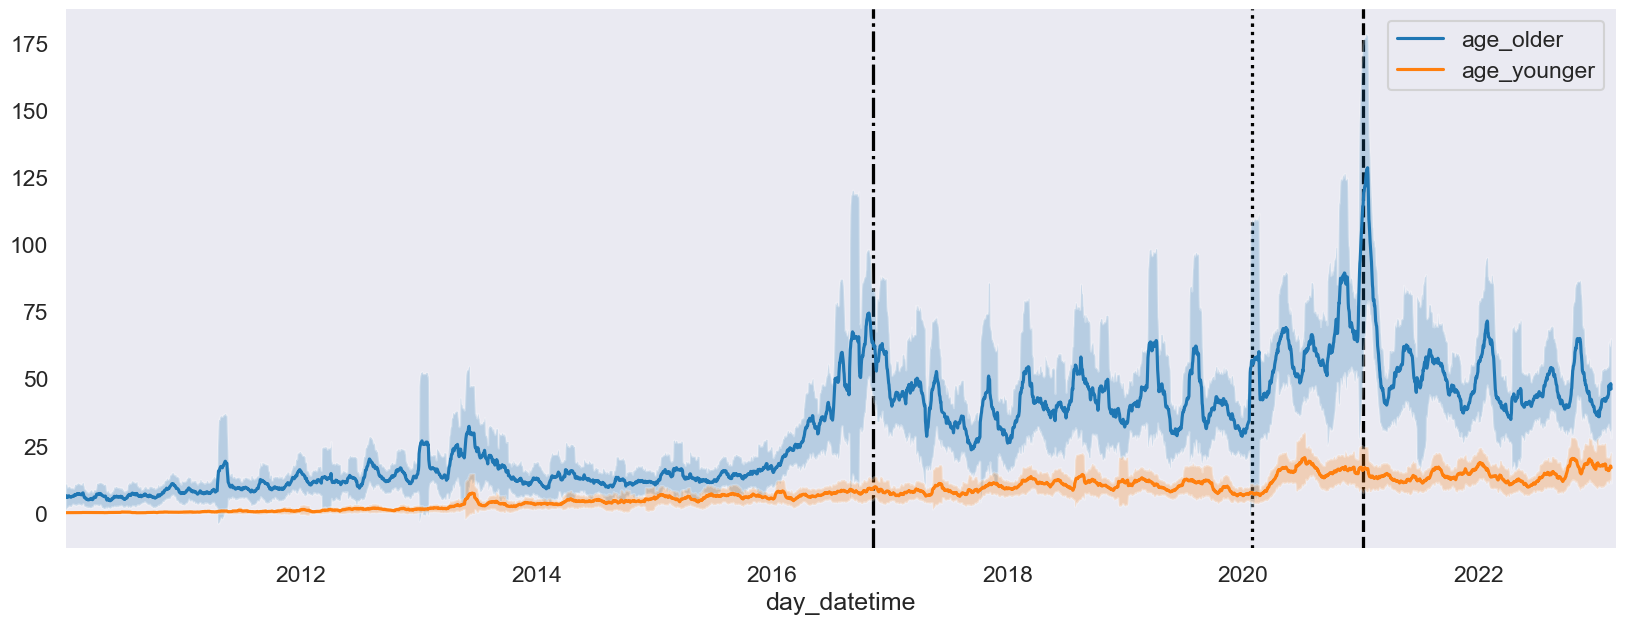

affluence


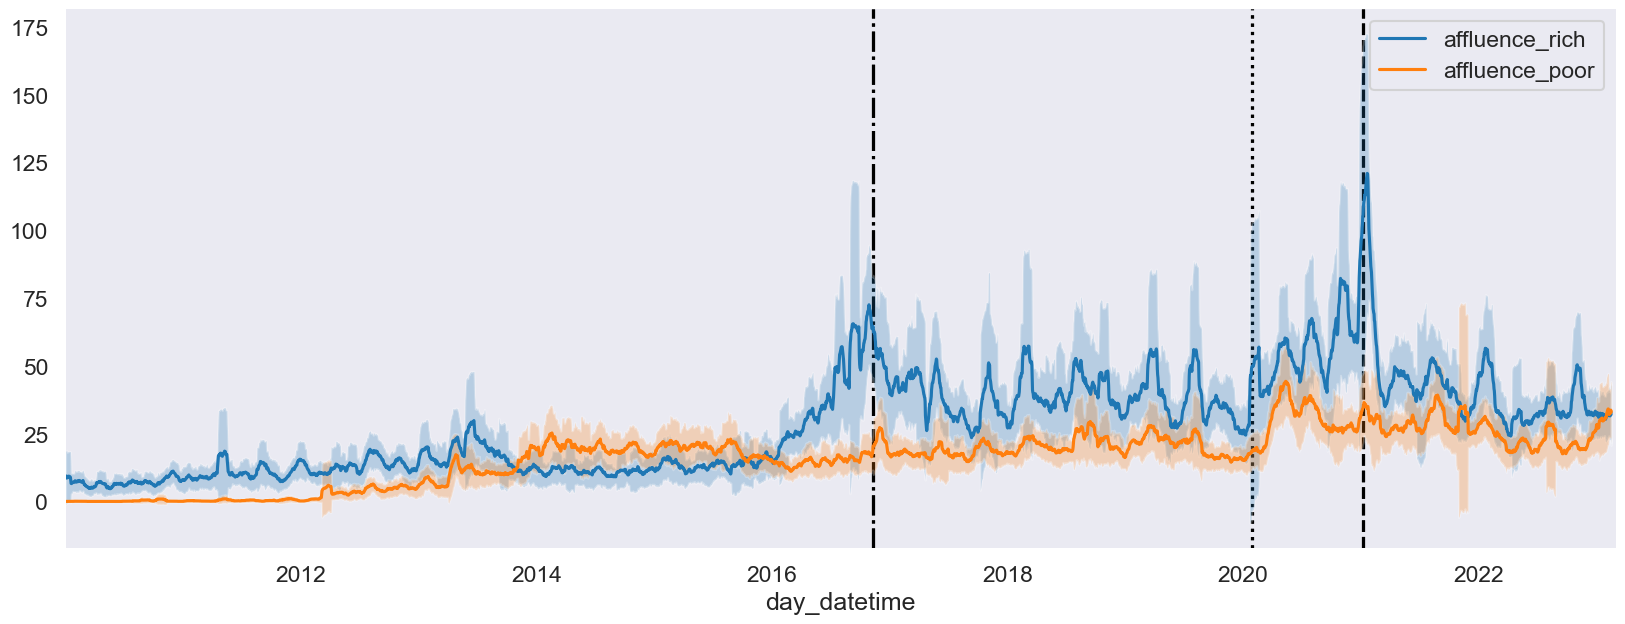

political


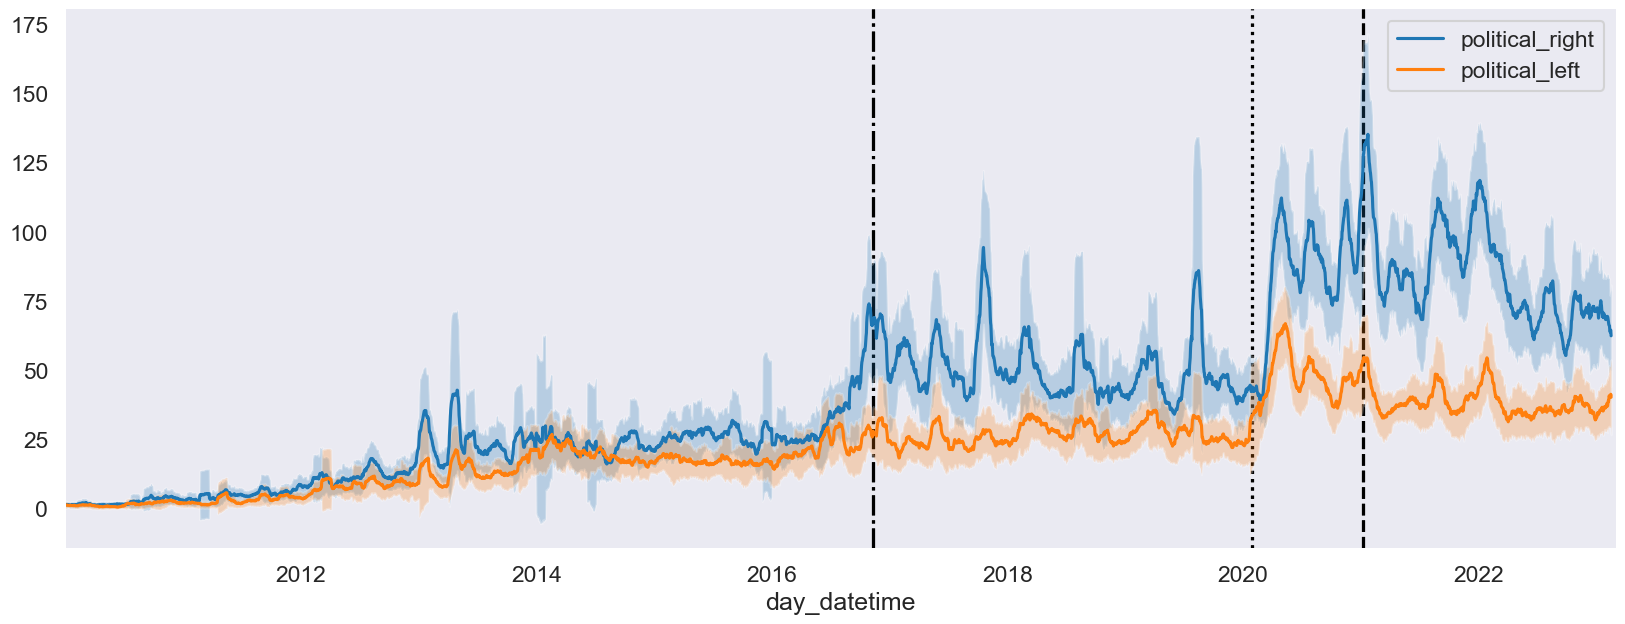

politics


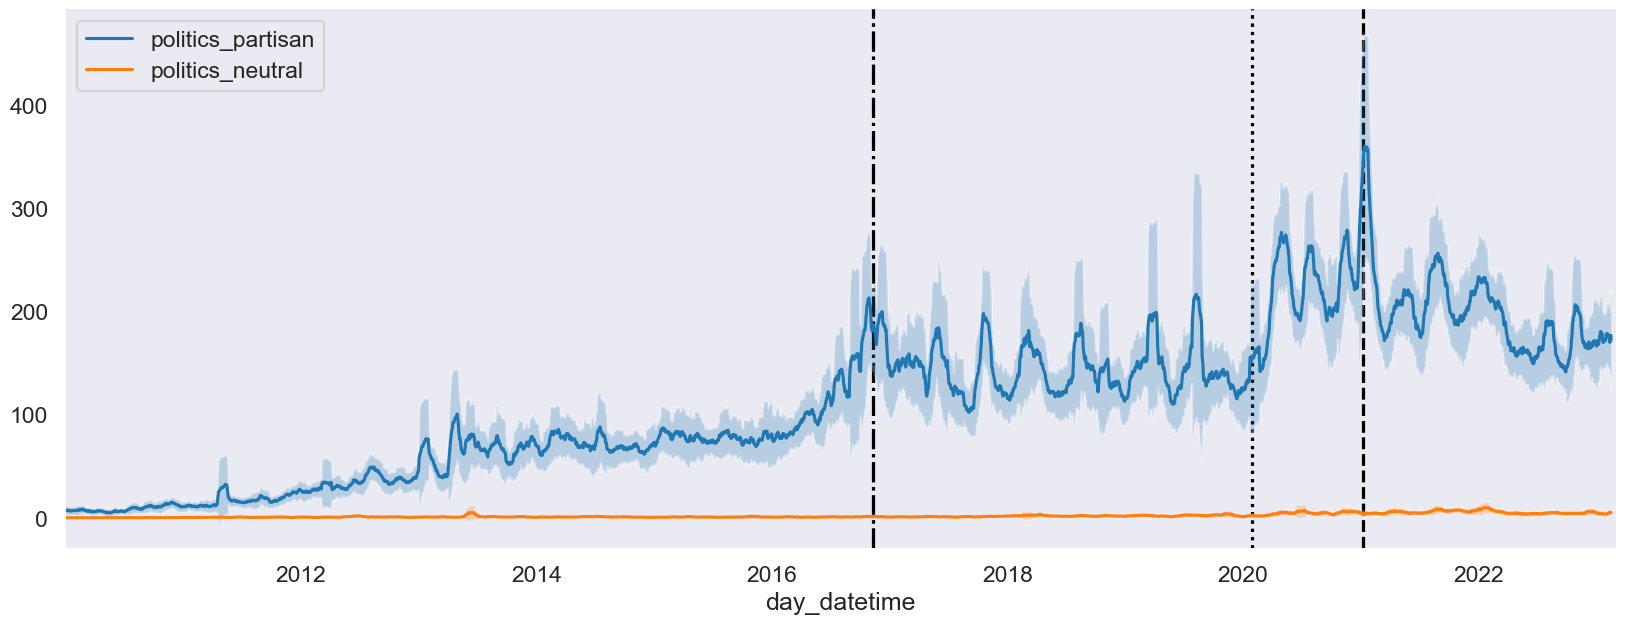

In [16]:


with sns.plotting_context("talk"):
    for col_filter in ['gender', 'affiliation', 'age', 'affluence', 'political', 'politics']:
        ax=None
        print(col_filter)
        for col in top_bottom_counters.columns:
            if col_filter not in col: continue
            roll = (df[col]).rolling(30, center=True)
            m = roll.agg(['mean', 'std'])
            m=m.loc[m.index>'2010']
            ax = m['mean'].rename(col).plot(figsize=(20, 7), ax=ax)
            ax.fill_between(m.index, m['mean'] - m['std'], m['mean'] + m['std'],
                            alpha=.25)
            plt.axvline(x = datetime.fromisoformat('2021-01-06'), color = 'k', ls='--', zorder=0)
            plt.axvline(x = datetime.fromisoformat('2020-01-30'), color = 'k', ls=':', zorder=0)
            plt.axvline(x = datetime.fromisoformat('2016-11-08'), color = 'k', ls='-.', zorder=0)
            plt.annotate('Capitol Hill attack', xy=(datetime.fromisoformat('2021-01-06'), 1000), rotation=90, va='bottom', ha='right', fontsize=16)
            plt.annotate('WHO COVID-19 emergency', xy=(datetime.fromisoformat('2020-01-30'), 1000), rotation=90, va='bottom', ha='right', fontsize=16)
            plt.annotate('election of Donald J. Trump', xy=(datetime.fromisoformat('2016-11-08'), 1000), rotation=90, va='bottom', ha='right', fontsize=16)
            sns.despine(ax=ax, left=True, bottom=True)
            ax.grid(False)
            # ax.set_ylim(-.001, .001)
        plt.legend()
        plt.show()

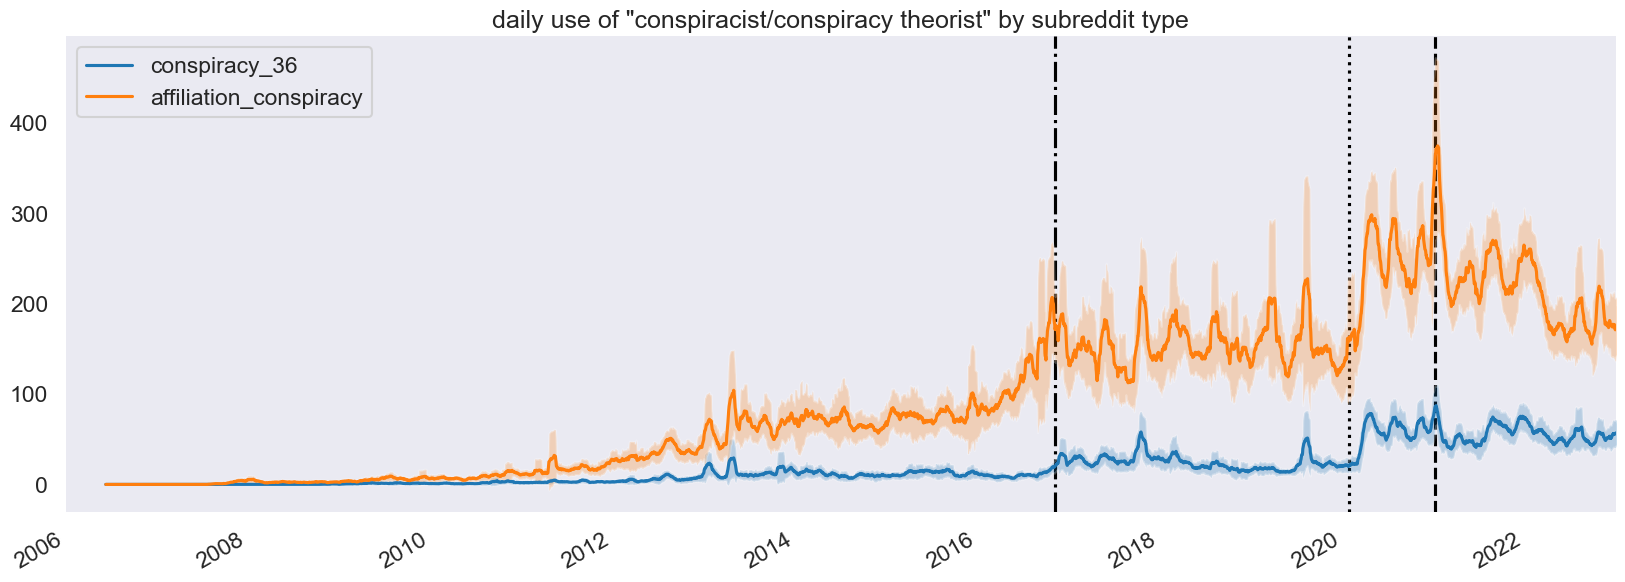

In [17]:
with sns.plotting_context("talk"):
    ax=None
    for col in [col for col in df.columns if 'conspiracy'  in col]:
        roll = df[col].rolling(30, center=True)
        m = roll.agg(['mean', 'std'])
        ax = m['mean'].rename(col).plot(figsize=(20, 7), ax=ax)
        ax.fill_between(m.index, m['mean'] - m['std'], m['mean'] + m['std'],
                        alpha=.25)
    _ = ax.set_title('daily use of "conspiracist/conspiracy theorist" by subreddit type')
    _ = ax.set_xlabel('')
    plt.axvline(x = datetime.fromisoformat('2021-01-06'), color = 'k', ls='--', zorder=0)
    plt.axvline(x = datetime.fromisoformat('2020-01-30'), color = 'k', ls=':', zorder=0)
    plt.axvline(x = datetime.fromisoformat('2016-11-08'), color = 'k', ls='-.', zorder=0)
    plt.annotate('Capitol Hill attack', xy=(datetime.fromisoformat('2021-01-06'), 1000), rotation=90, va='top', ha='right', fontsize=16)
    plt.annotate('WHO COVID-19 emergency', xy=(datetime.fromisoformat('2020-01-30'), 1000), rotation=90, va='top', ha='right', fontsize=16)
    plt.annotate('election of Donald J. Trump', xy=(datetime.fromisoformat('2016-11-08'), 1000), rotation=90, va='top', ha='right', fontsize=16)
    sns.despine(ax=ax, left=True, bottom=True)
    ax.grid(False)
    ax.set_xlim(datetime.fromisoformat('2006-01-01'), datetime.fromisoformat('2023-01-01'), )
    plt.legend(loc='upper left')
    # plt.savefig('../reports/figures/count_daily_labeling_smoothed.png', bbox_inches='tight', dpi=600)

In [18]:
perspectives = dict()
with open('../data/interim/perspective/labeling_contributions_preprocessed_no_bot_perspective.jsonl') as f:
    for l in map(json.loads, f):
        perspectives.update(l)
perspectives_parsed = {k: parse_summary_scores(v) for k, v in perspectives.items()}
idx, vals = zip(*perspectives_parsed.items())
perspect_df = pd.DataFrame(vals, index=idx)
perspect_df.head()
perspect_df.columns
# perspect_df = perspect_df.apply(zscore)
perspect_df= perspect_df[['ATTACK_ON_AUTHOR', 'ATTACK_ON_COMMENTER',
       'IDENTITY_ATTACK', 'INFLAMMATORY', 'INSULT',
       'THREAT', 'TOXICITY', 'UNSUBSTANTIAL', 'SEVERE_TOXICITY']]
# top_perspectives = perspect_df.idxmax(axis=1)

In [19]:
with pd.read_json('../data/interim/labeling_contributions_preprocessed_no_bot.jsonl', orient='records', lines=True, chunksize=500) as reader:
    df = pd.concat(chunk[chunk.contribution_type=='comment'][[ 'author', 'created_utc',
           'subreddit','text', 'fullname', 'parent_fullname',
           'link_fullname',]] for chunk in reader)


In [20]:
df = pd.merge(df, perspect_df, how='left', left_on='fullname', right_index=True)


In [21]:
df['created_dt'] = df.created_utc.apply(lambda x:datetime.fromtimestamp(x))

In [22]:
perspect_df.mean()

ATTACK_ON_AUTHOR       0.225823
ATTACK_ON_COMMENTER    0.404618
IDENTITY_ATTACK        0.068492
INFLAMMATORY           0.485634
INSULT                 0.209753
THREAT                 0.024559
TOXICITY               0.267349
UNSUBSTANTIAL          0.323666
SEVERE_TOXICITY        0.026885
dtype: float64

<Axes: xlabel='created_dt'>

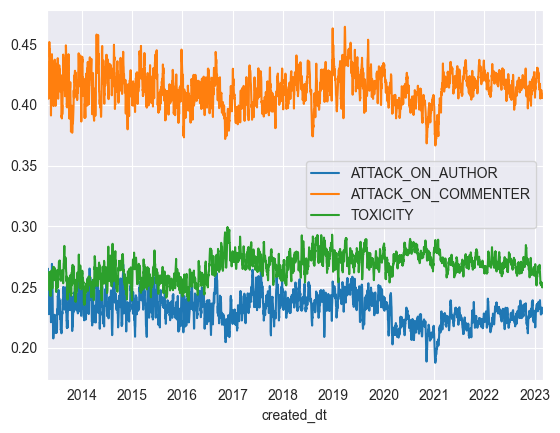

In [23]:
df.set_index('created_dt').resample('d')[[
    'ATTACK_ON_AUTHOR',
    'ATTACK_ON_COMMENTER',
    #    'IDENTITY_ATTACK', 
    # 'INFLAMMATORY',
    # 'INSULT',
    #    'THREAT',
    'TOXICITY',
    # 'UNSUBSTANTIAL',
    # 'SEVERE_TOXICITY'
]].mean().rolling(7, center=True).mean().tail(3600).plot()
        # roll = df[col].rolling(30, center=True)
        # m = roll.agg(['mean', 'std'])
        # ax = m['mean'].rename(col).plot(figsize=(20, 7), ax=ax)
        # ax.fill_between(m.index, m['mean'] - m['std'], m['mean'] + m['std'],
        #                 alpha=.25)


In [24]:
means_stds = dict()
for measure in ['social_dimensions', 'liwc', 'perspective']:

    subreddit_means = pd.read_json(f'../data/interim/{measure}/sample_contributions_10000_preprocessed_{measure}_subreddit_means.jsonl',
                 lines=True).set_index('subreddit')
    subreddit_stds = pd.read_json(f'../data/interim/{measure}/sample_contributions_10000_preprocessed_{measure}_subreddit_stds.jsonl',
                lines=True).set_index('subreddit')
    means_stds[measure] = (subreddit_means, subreddit_stds)
subreddit_means = pd.concat((i[0] for i in means_stds.values()), axis=1)
subreddit_stds = pd.concat((i[1] for i in means_stds.values()), axis=1)

In [79]:
with sns.plotting_context("talk"):
    ax = df.plot(figsize=(20, 7))
    _ = ax.set_title('daily use of "conspiracist/conspiracy theorist" by subreddit type')
    _ = ax.set_xlabel('')
    plt.axvline(x = datetime.fromisoformat('2021-01-06'), color = 'k', ls='--', zorder=0)
    plt.axvline(x = datetime.fromisoformat('2020-01-30'), color = 'k', ls=':', zorder=0)
    plt.annotate('Capitol Hill attack', xy=(datetime.fromisoformat('2021-01-06'), 1400), rotation=90, va='top', ha='right', fontsize=12)
    plt.annotate('WHO declares COVID-19 emergency', xy=(datetime.fromisoformat('2020-01-30'), 1400), rotation=90, va='top', ha='right', fontsize=12)
    sns.despine(ax=ax, left=True, bottom=True)
    ax.grid(False)
    ax.set_xlim(datetime.fromisoformat('2006-01-01'), datetime.fromisoformat('2023-01-01'), )
    plt.legend(loc='upper left')
    plt.savefig('../reports/figures/count_daily_labeling.png', bbox_inches='tight', dpi=600)

ValueError: Date ordinal -83881439.8999982 converts to -227690-06-03T02:24:00.155648 (using epoch 1970-01-01T00:00:00), but Matplotlib dates must be between year 0001 and 9999.

Error in callback <function _draw_all_if_interactive at 0x0000015D330EF2E0> (for post_execute):


ValueError: Date ordinal -83881439.8999982 converts to -227690-06-03T02:24:00.155648 (using epoch 1970-01-01T00:00:00), but Matplotlib dates must be between year 0001 and 9999.

ValueError: Date ordinal -83881439.8999982 converts to -227690-06-03T02:24:00.155648 (using epoch 1970-01-01T00:00:00), but Matplotlib dates must be between year 0001 and 9999.

<Figure size 2000x700 with 1 Axes>

In [ ]:
with sns.plotting_context("talk"):
    ax = df.resample('w').sum().plot(figsize=(20, 7))
    _ = ax.set_title('weekly use of "conspiracist/conspiracy theorist" by subreddit type')
    _ = ax.set_xlabel('')
    plt.axvline(x = datetime.fromisoformat('2021-01-06'), color = 'k', ls='--', zorder=0)
    plt.axvline(x = datetime.fromisoformat('2020-01-30'), color = 'k', ls=':', zorder=0)
    plt.axvline(x = datetime.fromisoformat('2016-11-08'), color = 'k', ls='-.', zorder=0)
    plt.annotate('Capitol Hill attack', xy=(datetime.fromisoformat('2021-01-06'), 7200), rotation=90, va='top', ha='right', fontsize=16)
    plt.annotate('WHO declares COVID-19 emergency', xy=(datetime.fromisoformat('2020-01-30'), 7200), rotation=90, va='top', ha='right', fontsize=16)
    plt.annotate('election of Donald J. Trump', xy=(datetime.fromisoformat('2016-11-08'), 7200), rotation=90, va='top', ha='right', fontsize=16)
    sns.despine(ax=ax, left=True, bottom=True)
    # ax.grid(False)
    ax.set_xlim(datetime.fromisoformat('2006-01-01'), datetime.fromisoformat('2023-01-01'), )
    plt.legend(loc='upper left')
    plt.savefig('../reports/figures/count_weekly_labeling.png', bbox_inches='tight', dpi=600)

In [ ]:
with sns.plotting_context("talk"):
    toplot = df.resample('w').sum()
    toplot['all'] = toplot['all']/toplot['all'].sum()
    toplot['conspiracy'] = toplot['conspiracy']/toplot['conspiracy'].sum()
    toplot['default'] = toplot['default']/toplot['default'].sum()
    ax = toplot.plot(figsize=(20, 7))
    _ = ax.set_title('weekly use of "conspiracist/conspiracy theorist" by subreddit type')
    _ = ax.set_xlabel('')
    plt.axvline(x = datetime.fromisoformat('2021-01-06'), color = 'k', ls='--', zorder=0)
    plt.axvline(x = datetime.fromisoformat('2020-01-30'), color = 'k', ls=':', zorder=0)
    plt.axvline(x = datetime.fromisoformat('2016-11-08'), color = 'k', ls='-.', zorder=0)
    plt.annotate('Capitol Hill attack', xy=(datetime.fromisoformat('2021-01-06'), 0.0065), rotation=90, va='top', ha='right', fontsize=16)
    plt.annotate('WHO declares COVID-19 emergency', xy=(datetime.fromisoformat('2020-01-30'), 0.0065), rotation=90, va='top', ha='right', fontsize=16)
    plt.annotate('election of Donald J. Trump', xy=(datetime.fromisoformat('2016-11-08'), 0.0065), rotation=90, va='top', ha='right', fontsize=16)
    sns.despine(ax=ax, left=True, bottom=True)
    # ax.grid(False)
    # ax.set_xlim(datetime.fromisoformat('2006-01-01'), datetime.fromisoformat('2023-01-01'), )
    plt.legend(loc='upper left')
    # plt.savefig('../reports/figures/count_weekly_labeling.png', bbox_inches='tight', dpi=600)

In [ ]:
with open('../data/interim/counts/all_counts.json') as f:
    bg_all = json.load(f)
    bg_all = pd.Series({datetime.fromtimestamp(float(k)).date(): v for k, v in bg_all.items()} ,name='bg')

with open('../data/interim/counts/ct_counts.json') as f:
    bg_ct = json.load(f)
    bg_ct = pd.Series({datetime.fromtimestamp(float(k)).date(): v for k, v in bg_ct.items()} ,name='bg')

with open('../data/interim/counts/default_counts.json') as f:
    bg_default = json.load(f)
    bg_default = pd.Series({datetime.fromtimestamp(float(k)).date(): v for k, v in bg_default.items()} ,name='bg')

In [ ]:
df2=df.copy()
df2['bg_all'] = bg_all
df2['bg_ct'] = bg_ct
df2['bg_default'] = bg_default

In [ ]:
with sns.plotting_context("talk"):
    toplot = df2.resample('m').sum()
    toplot['all'] = toplot['all']/toplot['all'].sum()
    toplot['conspiracy'] = toplot['conspiracy']/toplot['conspiracy'].sum()
    toplot['default'] = toplot['default']/toplot['default'].sum()
    toplot['bg_all'] = toplot['bg_all']/toplot['bg_all'].sum()
    toplot['bg_ct'] = toplot['bg_ct']/toplot['bg_ct'].sum()
    toplot['bg_default'] = toplot['bg_default']/toplot['bg_default'].sum()

    ax = toplot.plot(figsize=(20, 7))
    _ = ax.set_title('density of monthly use of "conspiracist/conspiracy theorist" by subreddit type')
    _ = ax.set_xlabel('')
    plt.axvline(x = datetime.fromisoformat('2021-01-06'), color = 'k', ls='--', zorder=0)
    plt.axvline(x = datetime.fromisoformat('2020-01-30'), color = 'k', ls=':', zorder=0)
    plt.axvline(x = datetime.fromisoformat('2016-11-08'), color = 'k', ls='-.', zorder=0)
    plt.annotate('Capitol Hill attack', xy=(datetime.fromisoformat('2021-01-06'), 0.023), rotation=90, va='top', ha='right', fontsize=16)
    plt.annotate('WHO declares COVID-19 emergency', xy=(datetime.fromisoformat('2020-01-30'), 0.023), rotation=90, va='top', ha='right', fontsize=16)
    plt.annotate('election of Donald J. Trump', xy=(datetime.fromisoformat('2016-11-08'), 0.023), rotation=90, va='top', ha='right', fontsize=16)
    sns.despine(ax=ax, left=True, bottom=True)
    # ax.grid(False)
    # ax.set_xlim(datetime.fromisoformat('2006-01-01'), datetime.fromisoformat('2023-01-01'), )
    plt.legend(loc='upper left')
    # plt.savefig('../reports/figures/count_weekly_labeling.png', bbox_inches='tight', dpi=600)
    plt.show()

    ax = toplot[['all', 'default', 'conspiracy']].plot(figsize=(20, 7))
    _ = ax.set_title('density of monthly use of "conspiracist/conspiracy theorist" by subreddit type')
    _ = ax.set_xlabel('')
    plt.axvline(x = datetime.fromisoformat('2021-01-06'), color = 'k', ls='--', zorder=0)
    plt.axvline(x = datetime.fromisoformat('2020-01-30'), color = 'k', ls=':', zorder=0)
    plt.axvline(x = datetime.fromisoformat('2016-11-08'), color = 'k', ls='-.', zorder=0)
    plt.annotate('Capitol Hill attack', xy=(datetime.fromisoformat('2021-01-06'), 0.023), rotation=90, va='top', ha='right', fontsize=16)
    plt.annotate('WHO declares COVID-19 emergency', xy=(datetime.fromisoformat('2020-01-30'), 0.023), rotation=90, va='top', ha='right', fontsize=16)
    plt.annotate('election of Donald J. Trump', xy=(datetime.fromisoformat('2016-11-08'), 0.023), rotation=90, va='top', ha='right', fontsize=16)
    sns.despine(ax=ax, left=True, bottom=True)
    # ax.grid(False)
    # ax.set_xlim(datetime.fromisoformat('2006-01-01'), datetime.fromisoformat('2023-01-01'), )
    plt.legend(loc='upper left')
    # plt.savefig('../reports/figures/count_weekly_labeling.png', bbox_inches='tight', dpi=600)
    plt.show()

    ax = toplot[['bg_all', 'bg_default', 'bg_ct']].plot(figsize=(20, 7))
    _ = ax.set_title('density of monthly contributions by subreddit type')
    _ = ax.set_xlabel('')
    plt.axvline(x = datetime.fromisoformat('2021-01-06'), color = 'k', ls='--', zorder=0)
    plt.axvline(x = datetime.fromisoformat('2020-01-30'), color = 'k', ls=':', zorder=0)
    plt.axvline(x = datetime.fromisoformat('2016-11-08'), color = 'k', ls='-.', zorder=0)
    plt.annotate('Capitol Hill attack', xy=(datetime.fromisoformat('2021-01-06'), 0.023), rotation=90, va='top', ha='right', fontsize=16)
    plt.annotate('WHO declares COVID-19 emergency', xy=(datetime.fromisoformat('2020-01-30'), 0.023), rotation=90, va='top', ha='right', fontsize=16)
    plt.annotate('election of Donald J. Trump', xy=(datetime.fromisoformat('2016-11-08'), 0.023), rotation=90, va='top', ha='right', fontsize=16)
    sns.despine(ax=ax, left=True, bottom=True)
    # ax.grid(False)
    # ax.set_xlim(datetime.fromisoformat('2006-01-01'), datetime.fromisoformat('2023-01-01'), )
    plt.legend(loc='upper left')
    # plt.savefig('../reports/figures/count_weekly_labeling.png', bbox_inches='tight', dpi=600)
    plt.show()


In [ ]:
df2 = df.copy()

In [ ]:
df2['all']/=bg_all
df2['conspiracy']/=bg_ct
df2['default']/=bg_default

In [ ]:
with sns.plotting_context("talk"):
    toplot = df2.resample('w').sum()

    ax = toplot.plot(figsize=(20, 7))
    _ = ax.set_title('fraction of weekly contributions using of "conspiracist/conspiracy theorist" by subreddit type')
    _ = ax.set_xlabel('')
    plt.axvline(x = datetime.fromisoformat('2021-01-06'), color = 'k', ls='--', zorder=0)
    plt.axvline(x = datetime.fromisoformat('2020-01-30'), color = 'k', ls=':', zorder=0)
    plt.axvline(x = datetime.fromisoformat('2016-11-08'), color = 'k', ls='-.', zorder=0)
    plt.annotate('Capitol Hill attack', xy=(datetime.fromisoformat('2021-01-06'), 0.0065), rotation=90, va='top', ha='right', fontsize=16)
    plt.annotate('WHO declares COVID-19 emergency', xy=(datetime.fromisoformat('2020-01-30'), 0.0065), rotation=90, va='top', ha='right', fontsize=16)
    plt.annotate('election of Donald J. Trump', xy=(datetime.fromisoformat('2016-11-08'), 0.0065), rotation=90, va='top', ha='right', fontsize=16)
    sns.despine(ax=ax, left=True, bottom=True)
    # ax.grid(False)
    # ax.set_xlim(datetime.fromisoformat('2006-01-01'), datetime.fromisoformat('2023-01-01'), )
    ax.set_ylim(0, 0.05)
    plt.legend(loc='upper left')
    # plt.savefig('../reports/figures/count_weekly_labeling.png', bbox_inches='tight', dpi=600)
    plt.show()

    ax = toplot.plot(figsize=(20, 7))
    _ = ax.set_title('fraction of weekly contributions using of "conspiracist/conspiracy theorist" by subreddit type')
    _ = ax.set_xlabel('')
    plt.axvline(x = datetime.fromisoformat('2021-01-06'), color = 'k', ls='--', zorder=0)
    plt.axvline(x = datetime.fromisoformat('2020-01-30'), color = 'k', ls=':', zorder=0)
    plt.axvline(x = datetime.fromisoformat('2016-11-08'), color = 'k', ls='-.', zorder=0)
    plt.annotate('Capitol Hill attack', xy=(datetime.fromisoformat('2021-01-06'), 0.0065), rotation=90, va='top', ha='right', fontsize=16)
    plt.annotate('WHO declares COVID-19 emergency', xy=(datetime.fromisoformat('2020-01-30'), 0.0065), rotation=90, va='top', ha='right', fontsize=16)
    plt.annotate('election of Donald J. Trump', xy=(datetime.fromisoformat('2016-11-08'), 0.0065), rotation=90, va='top', ha='right', fontsize=16)
    sns.despine(ax=ax, left=True, bottom=True)
    # ax.grid(False)
    # ax.set_xlim(datetime.fromisoformat('2006-01-01'), datetime.fromisoformat('2023-01-01'), )
    ax.set_ylim(0, 0.002)
    plt.legend(loc='upper left')
    # plt.savefig('../reports/figures/count_weekly_labeling.png', bbox_inches='tight', dpi=600)
    plt.show()

In [ ]:
with sns.plotting_context("talk"):
    toplot = df2.resample('w').sum()
    toplot['all'] = toplot['all']/toplot['all'].sum()
    toplot['conspiracy'] = toplot['conspiracy']/toplot['conspiracy'].sum()
    toplot['default'] = toplot['default']/toplot['default'].sum()
    ax = toplot.plot(figsize=(20, 7))
    _ = ax.set_title('fraction of weekly contributions using of "conspiracist/conspiracy theorist" by subreddit type')
    _ = ax.set_xlabel('')
    plt.axvline(x = datetime.fromisoformat('2021-01-06'), color = 'k', ls='--', zorder=0)
    plt.axvline(x = datetime.fromisoformat('2020-01-30'), color = 'k', ls=':', zorder=0)
    plt.axvline(x = datetime.fromisoformat('2016-11-08'), color = 'k', ls='-.', zorder=0)
    plt.annotate('Capitol Hill attack', xy=(datetime.fromisoformat('2021-01-06'), 0.0065), rotation=90, va='top', ha='right', fontsize=16)
    plt.annotate('WHO declares COVID-19 emergency', xy=(datetime.fromisoformat('2020-01-30'), 0.0065), rotation=90, va='top', ha='right', fontsize=16)
    plt.annotate('election of Donald J. Trump', xy=(datetime.fromisoformat('2016-11-08'), 0.0065), rotation=90, va='top', ha='right', fontsize=16)
    sns.despine(ax=ax, left=True, bottom=True)
    # ax.grid(False)
    # ax.set_xlim(datetime.fromisoformat('2006-01-01'), datetime.fromisoformat('2023-01-01'), )
    ax.set_ylim(0, 0.003)
    plt.legend(loc='upper left')
    # plt.savefig('../reports/figures/count_weekly_labeling.png', bbox_inches='tight', dpi=600)
    plt.show()


In [ ]:
with sns.plotting_context("talk"):
    toplot = df2.resample('m').sum()
    toplot['all'] = toplot['all']/toplot['all'].sum()
    toplot['conspiracy'] = toplot['conspiracy']/toplot['conspiracy'].sum()
    toplot['default'] = toplot['default']/toplot['default'].sum()
    ax = toplot.plot(figsize=(20, 7))
    _ = ax.set_title('fraction of monthly contributions using of "conspiracist/conspiracy theorist" by subreddit type')
    _ = ax.set_xlabel('')
    plt.axvline(x = datetime.fromisoformat('2021-01-06'), color = 'k', ls='--', zorder=0)
    plt.axvline(x = datetime.fromisoformat('2020-01-30'), color = 'k', ls=':', zorder=0)
    plt.axvline(x = datetime.fromisoformat('2016-11-08'), color = 'k', ls='-.', zorder=0)
    plt.annotate('Capitol Hill attack', xy=(datetime.fromisoformat('2021-01-06'), 0.02), rotation=90, va='top', ha='right', fontsize=16)
    plt.annotate('WHO declares COVID-19 emergency', xy=(datetime.fromisoformat('2020-01-30'), 0.02), rotation=90, va='top', ha='right', fontsize=16)
    plt.annotate('election of Donald J. Trump', xy=(datetime.fromisoformat('2016-11-08'), 0.02), rotation=90, va='top', ha='right', fontsize=16)
    sns.despine(ax=ax, left=True, bottom=True)
    # ax.grid(False)
    # ax.set_xlim(datetime.fromisoformat('2006-01-01'), datetime.fromisoformat('2023-01-01'), )
    ax.set_ylim(0, 0.02)
    ax.set_ylabel('density')
    plt.legend(loc='upper center')
    # plt.savefig('../reports/figures/count_weekly_labeling.png', bbox_inches='tight', dpi=600)
    plt.show()


In [ ]:
with sns.plotting_context("talk"):
    ax=None
    toplot = df2.copy()
    toplot['all'] = toplot['all']/toplot['all'].sum()
    toplot['conspiracy'] = toplot['conspiracy']/toplot['conspiracy'].sum()
    toplot['default'] = toplot['default']/toplot['default'].sum()
    for col in toplot.columns:
        roll = toplot[col].rolling(30, center=True)
        m = roll.agg(['mean', 'std'])
        ax = m['mean'].rename(col).plot(figsize=(20, 7), ax=ax)
        ax.fill_between(m.index, m['mean'] - m['std'], m['mean'] + m['std'],
                        alpha=.25)
    _ = ax.set_title('daily use of "conspiracist/conspiracy theorist" by subreddit type')
    _ = ax.set_xlabel('')
    plt.axvline(x = datetime.fromisoformat('2021-01-06'), color = 'k', ls='--', zorder=0)
    plt.axvline(x = datetime.fromisoformat('2020-01-30'), color = 'k', ls=':', zorder=0)
    plt.axvline(x = datetime.fromisoformat('2016-11-08'), color = 'k', ls='-.', zorder=0)
    plt.annotate('Capitol Hill attack', xy=(datetime.fromisoformat('2021-01-06'), 1000), rotation=90, va='top', ha='right', fontsize=16)
    plt.annotate('WHO COVID-19 emergency', xy=(datetime.fromisoformat('2020-01-30'), 1000), rotation=90, va='top', ha='right', fontsize=16)
    plt.annotate('election of Donald J. Trump', xy=(datetime.fromisoformat('2016-11-08'), 1000), rotation=90, va='top', ha='right', fontsize=16)
    sns.despine(ax=ax, left=True, bottom=True)
    ax.grid(False)
    ax.set_xlim(datetime.fromisoformat('2006-01-01'), datetime.fromisoformat('2023-01-01'), )
    ax.set_ylim(0, .0004)
    plt.legend(loc='upper left')
    # plt.savefig('../reports/figures/count_daily_labeling.png', bbox_inches='tight', dpi=600)

In [ ]:
liwcs = dict()
with open('../data/interim/liwc/labeling_contributions_preprocessed_no_bot_liwc.jsonl') as f:
    for l in map(json.loads, f):
        liwcs.update(l)
idx, vals = zip(*liwcs.items())
liwcs_df = pd.DataFrame(vals, index=idx)
liwcs_df.head()
liwcs_df = liwcs_df.divide(liwcs_df.Tokens, axis=0)
del liwcs_df['Tokens']
liwcs_df = liwcs_df.apply(zscore)
liwcs_df = liwcs_df[[
    'Posemo', 'Negemo', 'Anger', 'Anx', 'Cause', 'Sad',
    'CogProc', 'Power','Affiliation', 'Reward', 'Risk',  'Social', 'Assent', 'friend',
    'Certain', 'Compare', 'Discrep', 'Insight', 'Interrog', 'Negate', 'Swear', 'Tentat', 'Relativ',
    'We', 'You', 'I', 'Ipron', 'they', 'SheHe', 'differ']]
top_liwcs = liwcs_df.idxmax(axis=1)

In [ ]:
perspectives = dict()
with open('../data/interim/perspective/labeling_contributions_preprocessed_no_bot_perspective.jsonl') as f:
    for l in map(json.loads, f):
        perspectives.update(l)
perspectives_parsed = {k: parse_summary_scores(v) for k, v in perspectives.items()}
idx, vals = zip(*perspectives_parsed.items())
perspect_df = pd.DataFrame(vals, index=idx)
perspect_df.head()
perspect_df.columns
perspect_df = perspect_df.apply(zscore)
perspect_df= perspect_df[['ATTACK_ON_AUTHOR', 'ATTACK_ON_COMMENTER',
       'IDENTITY_ATTACK', 'INFLAMMATORY', 'INSULT',
       'THREAT', 'TOXICITY', 'UNSUBSTANTIAL']]
top_perspectives = perspect_df.idxmax(axis=1)

In [ ]:
contribs = dict()
with open('../data/interim/labeling_contributions_preprocessed_no_bot.jsonl') as f:
    for l in map(json.loads, f):
        if 'subreddit' not in l:
            continue
        contribs[l['fullname']] = dict(subreddit = l['subreddit'], score = l['score'])

In [ ]:
df_contribs = pd.DataFrame(contribs).T

In [ ]:
subreddit_types = defaultdict(lambda: 'other')
for i in CONSPIRACY_SUBREDDITS:
    subreddit_types[i] = 'conspiracy'
for i in DEFAULT_SUBREDDITS:
    subreddit_types[i] = 'default'

df_contribs['subreddit_type'] = df_contribs.subreddit.map(subreddit_types)

In [ ]:
toplot = pd.DataFrame({'perspective':top_perspectives, 'liwc':top_liwcs, 'subreddit':df_contribs.subreddit})

In [ ]:
ax = toplot.groupby('subreddit').size().sort_values(ascending=False).reset_index(drop=True)
ax_ = ax.plot()
ax_.set_xlim(0, 50)
interesting_subs = set(toplot.groupby('subreddit').size().sort_values(ascending=False).head(20).index)
toplot = toplot[toplot.subreddit.isin(interesting_subs)]

In [ ]:
toplot

In [ ]:
plot_mca(df_toplot=toplot, fpath='../reports/figures/mca.html')

In [ ]:
perspectives_parsed = {k: parse_summary_scores(v) for k, v in perspectives.items()}
idx, vals = zip(*perspectives_parsed.items())
perspect_df_ = pd.DataFrame(vals, index=idx)


In [ ]:
pca_pronouns = PCA(2)
pronouns = pca_pronouns.fit_transform( liwcs_df[[ 'We', 'You', 'I', 'they']])
pronouns = pd.Series(pronouns[:, 0].ravel(), name = 'pronouns', index=liwcs_df.index)

pca_perspect = PCA(1)
perspect = pca_perspect.fit_transform( perspect_df_)
perspect = pd.Series(perspect.ravel(), name = 'pronouns', index=perspect_df_.index)

df_2d = pd.DataFrame(dict(pronouns=pronouns, toxicity=perspect_df_.TOXICITY, subreddit=df_contribs.subreddit))

In [ ]:
pca_perspect.explained_variance_ratio_

In [ ]:
pca_pronouns.explained_variance_ratio_

In [ ]:
sorted(zip(pca_pronouns.components_[0], [ 'We', 'You', 'I', 'they']))

In [ ]:
sorted(zip(pca_perspect.components_[0], perspect_df_.columns))

In [ ]:
df_2d.groupby('subreddit').mean().reset_index().sort_values(['pronouns', 'toxicity'], ascending=False)

In [ ]:
df_2d['subreddit_type'] = df_2d.subreddit.map(subreddit_types)

In [ ]:
import plotly.express as px

In [ ]:
px.scatter(df_2d.groupby(['subreddit', 'subreddit_type']).mean().reset_index(), x='toxicity', y='pronouns', hover_name='subreddit', color='subreddit_type')

In [ ]:
def get_toplot_to_pca():
    idx, vals = zip(*perspectives_parsed.items())
    perspect_df = pd.DataFrame(vals, index=idx)
    perspect_df.head()
    perspect_df.columns
    perspect_df = perspect_df.apply(zscore)

    idx, vals = zip(*liwcs.items())
    liwcs_df = pd.DataFrame(vals, index=idx)
    liwcs_df.head()
    liwcs_df = liwcs_df.divide(liwcs_df.Tokens, axis=0)
    del liwcs_df['Tokens']
    liwcs_df = liwcs_df.apply(zscore)
    toplot = pd.merge(liwcs_df, perspect_df, left_index=True, right_index=True)
    toplot = pd.merge(df_contribs[['subreddit', 'subreddit_type']], toplot, right_index=True, left_index=True)
    return toplot.groupby(['subreddit', 'subreddit_type']).mean()

In [ ]:
# toplot = get_toplot_to_pca()

toplot = pd.merge(liwcs_df, perspect_df, left_index=True, right_index=True)
toplot = pd.merge(df_contribs[['subreddit', 'subreddit_type']], toplot, right_index=True, left_index=True)
toplot = toplot.groupby(['subreddit', 'subreddit_type']).mean()

In [ ]:
pca=PCA(2)
transformed = pca.fit_transform(toplot)

In [ ]:
pca.explained_variance_ratio_

In [ ]:
sorted(zip(pca.components_[0], toplot.columns)) # us vs attack on commenter

In [ ]:
sorted(zip(pca.components_[1], toplot.columns)) # toxic vs unsubstantial

In [ ]:
transformed_df = pd.DataFrame(transformed, index=toplot.index)

In [ ]:
transformed_df.columns = ['c1', 'c2']

In [ ]:
px.scatter(transformed_df.reset_index().rename(columns={'c1': 'I/We <--> CogProg/attack on commenter', 'c2':"unsubstantial/tentat <--> insult/toxicity"}), x='I/We <--> CogProg/attack on commenter', y="unsubstantial/tentat <--> insult/toxicity", hover_name='subreddit', color='subreddit_type')

TODO: scale perspective scores against those of the whole subreddit

In [ ]:
iyou=pd.DataFrame(dict(iyou = toplot.I-toplot.You, usthem=toplot.We-toplot.they), index=toplot.index)

In [ ]:
px.scatter(iyou.reset_index(), x='iyou', y="usthem", hover_name='subreddit', color='subreddit_type')